In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import scipy as sp
from scipy.integrate import odeint,quad,simps,trapz
from scipy.special import eval_hermite,eval_hermitenorm
from math import sqrt,sin,pi,cos,exp,log,factorial
import sys
sys.path.append(r'/mnt/c/Users/Alejandro Lopez/Imperial College London/MSc Project - Alejandro López - MA - General/repository')
from nonparametric_generator import *

# Estimation of the operator $\mathcal{L}$

$$V(x) =- \frac{1}{2}x^2 +\frac{1}{4}x^4$$

\begin{align}
dX_t &= -\nabla V(X_t)dt + \sqrt{2D} dW_t \\
dX_t &= X_t(1-X_t^2)dt +\sqrt{2D} dW_t \\
X_0 &= 0 \\
\end{align}

In [2]:
V = lambda x:  -(1/2)*x**2 + (1/4)*x**4
DV = lambda x:  -x*(1-x**2)

def QWSimulation(x0, n,dt,D):
    """
    Function to create the trayectory of a OU process
    with difussion paramter D 

    :param x0: Intial position
    :param n:  Number of steps
    "param dt: Step size
    :param D:  Difussion parameter

    :return X: Trajectory
    """
    t = np.linspace(x0,dt*n,n)
    X = np.zeros((n,1))
    noise = np.random.normal(loc=0,scale=np.sqrt(dt),size=(n,1))
    for i in range(1,n):
        x = X[i-1,:]
        X[i,:] = x + (-DV(x))*dt +np.sqrt(2*D) * noise[i,:]
    return(X)

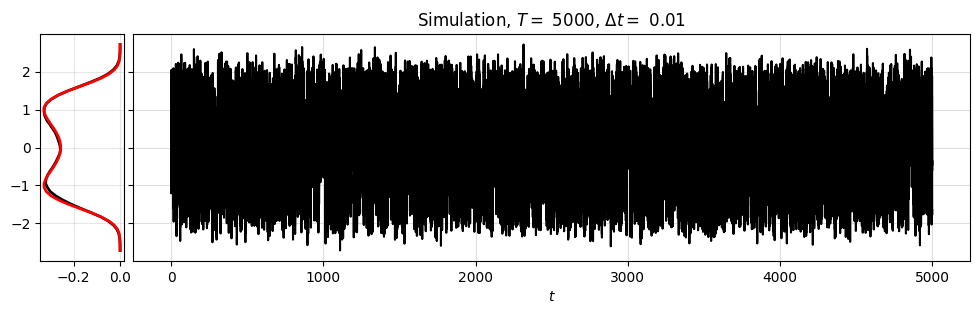

In [3]:
x0 = 0
n = 500000
dt = 1e-2
T = dt*n
D = 1
np.random.seed(1)
X = QWSimulation(x0,n,dt,D)


gs1 = GridSpec(1, 2, width_ratios=[1,10],wspace=0.02,hspace=0.3)
fig = plt.figure(figsize=(12,3),dpi=100)
ax1 = fig.add_subplot(gs1[1])
_ = ax1.plot(np.linspace(x0,n*dt,n), X[:,0],color='black')
_ = ax1.grid(alpha=0.4)
_ = ax1.set_xlabel("$t$")
_ = ax1.set_ylabel("$X_t$")
_ = ax1.set_title(f"Simulation, $T=$ {T:.0f}, $\Delta t =$ {dt}")
p_eq = density_estimation(X)
p_inf = lambda x: np.exp(-V(x)/D)
Z = trapz(x=np.linspace(-10,10),y= p_inf(np.linspace(-10,10)))
ax2 = fig.add_subplot(gs1[0])
_ = ax2.plot([-p_eq([x]) for x in np.linspace(min(X),max(X))],np.linspace(min(X),max(X)),color='k',lw=2)
_ = ax2.plot([-p_inf(x)/Z for x in np.linspace(min(X),max(X))],np.linspace(min(X),max(X)),color='r',lw=2)
_ = ax2.grid(alpha=0.3)

In [4]:
N = 2000
X_s = X[np.random.choice(range(n),size=N),:]

epsilon = 6.17e-06
d = 0.50


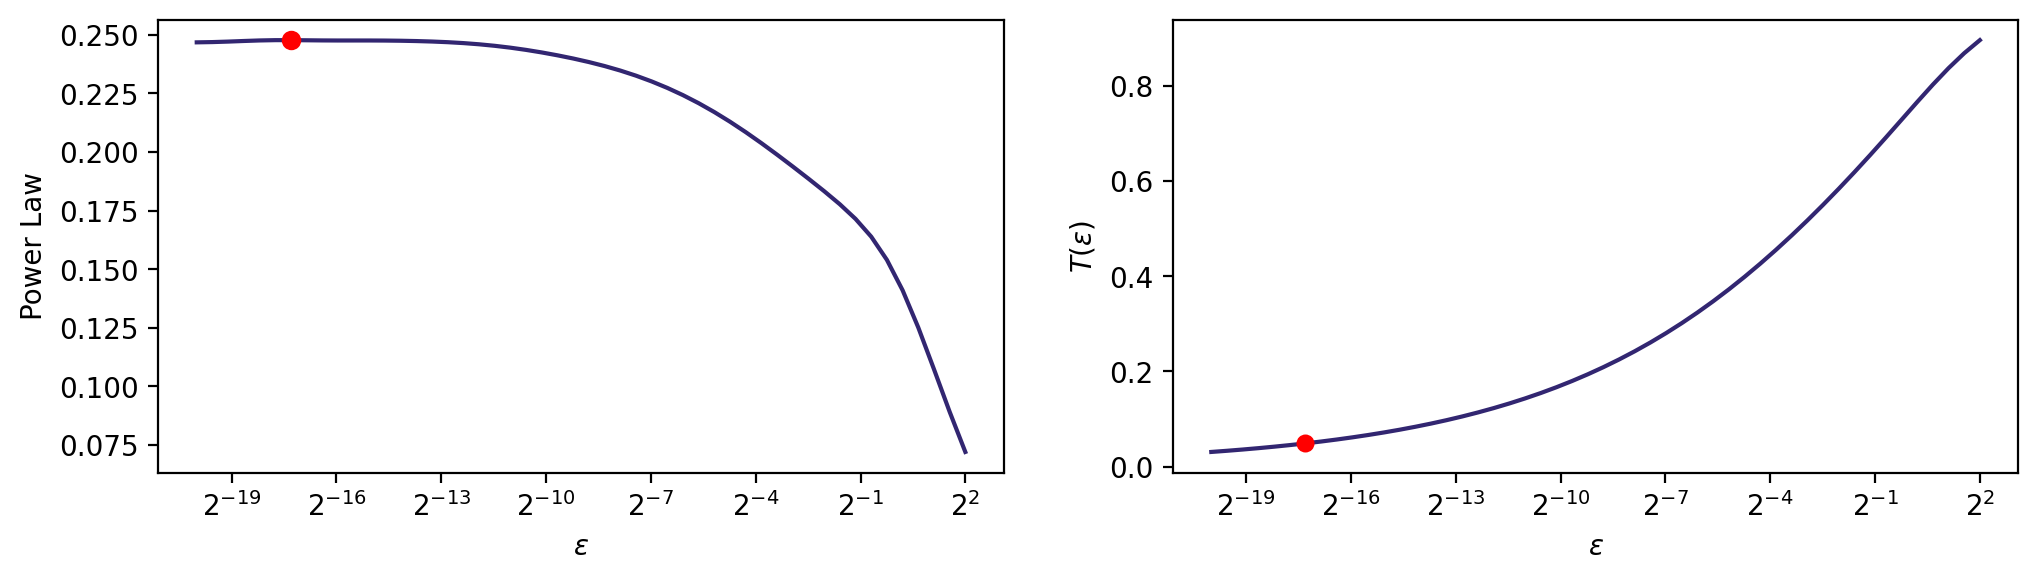

In [5]:
epsilon, d = bandwidth_search(X_s,plot=True,verbose=True)

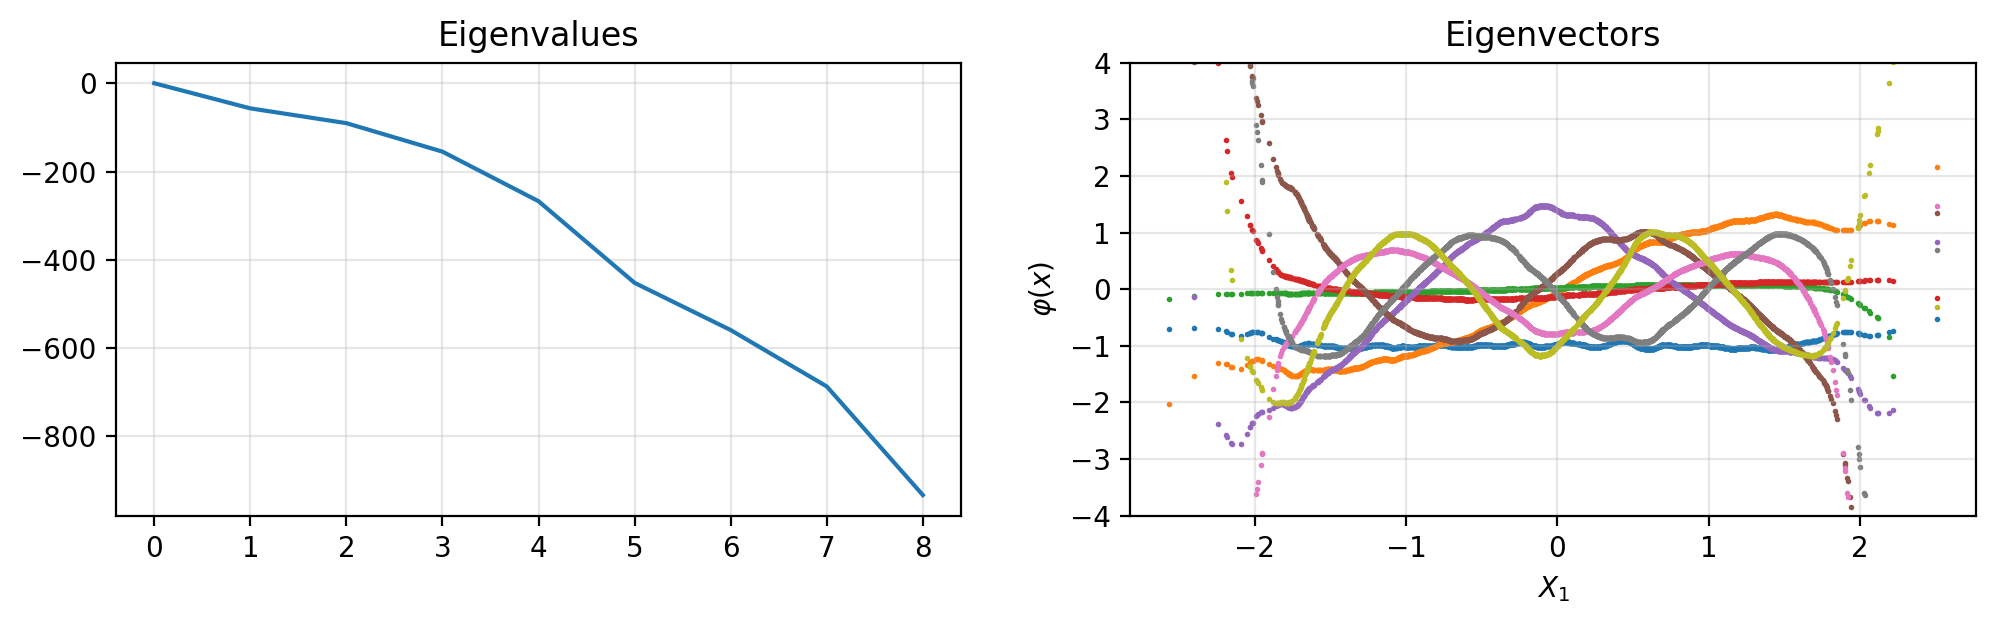

In [6]:
l, phi,L_e, U = KNPGenerator(X_s,M=9,plot=True,return_extra=True)
phi_1 = np.linalg.pinv(phi)

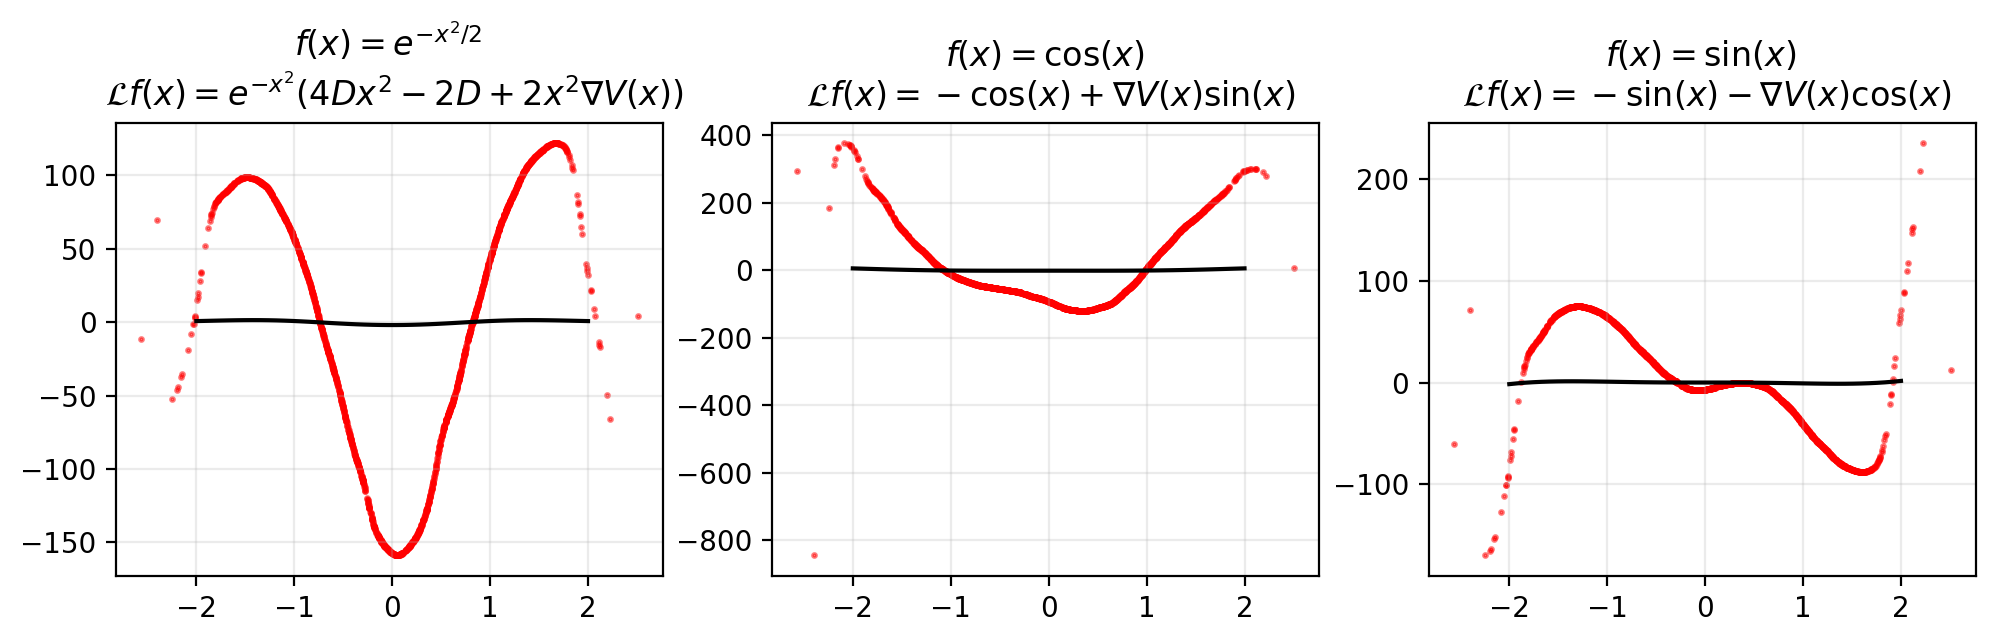

In [7]:
fig,axs = plt.subplots(1,3,figsize=(12,3),dpi=200)

x = np.linspace(-2,2)

Y = np.exp(-X_s[:,0]**2)
c_coef = D*(phi_1@Y)
axs[0].set_title("$f(x) =e^{-x^2/2} $ \n $\mathcal{L}f(x) = e^{-x^2}(4Dx^2-2D + 2x^2\\nabla V(x)) $")
axs[0].plot(x, D*np.exp(-x**2)*(4*x**2-2) + DV(x)*2*x*np.exp(-x**2),color='k')
axs[0].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',alpha=0.5)
axs[0].grid(alpha=0.25)

Y = np.cos(X_s[:,0])
c_coef =D*(phi_1@Y)
axs[1].set_title("$f(x) =\cos(x) $ \n $\mathcal{L}f(x) = -\cos(x)+\\nabla V(x)\sin(x) $")
axs[1].plot(x,-D*np.cos(x) + DV(x) * np.sin(x),color='k')
axs[1].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',alpha=0.5)
axs[1].grid(alpha=0.25)

Y = np.sin(X_s[:,0])
c_coef = D*(phi_1@Y)
axs[2].set_title("$f(x) =\sin(x) $ \n $\mathcal{L}f(x) = -\sin(x)-\\nabla V(x)\cos(x) $")
axs[2].plot(x,-D*np.sin(x) - DV(x) * np.cos(x),color='k')
axs[2].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',label='Computing coefficients for $\\varphi$',alpha=0.5)

axs[2].grid(alpha=0.25)

In [ ]:
l, phi,L_e, U = KNPGenerator(X_s,M=1000,plot=False,return_extra=True)
phi_1 = np.linalg.pinv(phi)

In [ ]:
E = np.zeros(1000)
for i in range(1,1001):
    Y = np.exp(-X_s[:,0]**2)
    c_coef = D*(phi_1[:i]@Y)
    E[i-1] = (1/N) * np.sum(np.abs(np.sum((c_coef*l[:i]) * phi[:,:i],axis=1) - \
          D*np.exp(-X_s[:,0]**2)*(4*X_s[:,0]**2-2) + DV(X_s[:,0])*2*X_s[:,0]*np.exp(-X_s[:,0]**2)))


In [ ]:
plt.figure(figsize=(16,3))
plt.plot(range(1,1001),E)

In [ ]:
S = np.sum(X - X.mean(),axis=1)
n = len(S)
C_tau=np.zeros(n)
C0 = (1/n) * np.sum(S**2)
for j in range(1,n):
    if 1/(n-j)*sum(S[:n-j]*S[j:]) > 0:
        C_tau[j] = 1/(n-j)*sum(S[:n-j]*S[j:])
    else:
        break
C_tau = C_tau[C_tau>0]
pv = len(C_tau)
Tc = simps(x=np.linspace(0,n*dt,n)[:pv],y= C_tau / C0)

_ = plt.grid(alpha=0.35)
_ = plt.plot(np.linspace(0,n*dt,n)[:pv],C_tau / C0 ,color='k',lw=2)
_ = plt.fill_between(np.linspace(0,n*dt,n)[:pv],C_tau / C0 ,color='k',lw=2,alpha=0.2)
_ = plt.xlabel('$\\tau$')
_ = plt.title(f'$T_c = {Tc:.3f}$')

In [ ]:
S = np.sum(X_s - X_s.mean(),axis=1)
s1 = np.sum((1/l) * (S.T@phi)**2)
s2 = np.sum((S.T@phi)**2)
D = - (1/Tc)* (s1/s2)
D

In [ ]:
p_0 = np.vectorize(lambda x: (1/np.sqrt(2*pi))* np.exp((-(x)**2)/2) )
p_eq = density_estimation(X_s)
rho_eq = np.vectorize(lambda x: p_eq(x)[0])

c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s))) * phi,axis=0)

In [ ]:
Lambda = np.diag(l)
D = 1
def RHS(y,t):
    return((D*Lambda) @ y)

init = 0
tf = 5
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,c_0,tarray,args=())

In [ ]:
_ = plt.figure(figsize=(7,4),dpi=100)
X_sort = np.sort(np.ravel(X_s))
N = len(X_s)
dx = np.diff(X_sort)
plt.figure(figsize=(10,5),dpi=200)
for t in [0,5,10,20,50,80,99]:
    est_density = np.zeros(N,)
    for i in range(N):
        est_density[i] =  rho_eq (X_s[i])* np.sum(csol[t] * phi[i,:])

    est_density=est_density[np.argsort(np.ravel(X_s))]
    cum = trapz(x=X_sort,y= est_density.T)
    plt.plot(X_sort,(1/cum) *est_density,lw=1,color=plt.cm.plasma(t/100))
    
    

plt.plot(np.linspace(min(X_s),max(X_s),100),p_0(np.linspace(min(X_s),max(X_s),100)),
         color='k',marker='x',ms=5,alpha=0.7)
plt.xlabel('$x$')
plt.ylabel('$p(t,x)$')
plt.grid(alpha=0.3)